# Анализ поведения пользователей мобильного приложения по продаже продуктов питания. Анализ результатов А/А/В-эксперимента.

## Введение

Данный проект направлен на проведение анализа поведения пользователей мобильного приложения по продаже продуктов питания, а также результатов А/А/В-эксперимента, проводимого с целью получения информации о реакции пользователей на изменение шрифтов во всем приложении. Целью данного проекта является изучение данного эксперимента для выявления его значимой эффективности.

Проведения данного исследования будет базироваться на массиве данных, содержащем информацию о:

- пользователях и совершенных ими событиях;
- делении пользователей на три группы для проведения эксперимента: две контрольные со старыми визуальными характеристиками приложения и одной экспериментальной - с новыми визуальными характеристиками приложения.

В ходе проведения данного исследования планируется проведение:

- проверки данных;
- анализа воронки событий;
- анализа результатов эксперимента.

По итогам выполнения каждого пункта проекта будут сделаны промежуточные выводы. В заключении проекта будет сформирован вывод по резальтатам проведенного анализа с указанием имеющихся предположений и заключением об эффективности проводимых изменений в приложении.

## Подготовка данных

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import seaborn as sns
import math as mth
from plotly import graph_objects as go

Загрузим и изучим представленный для анализа массив данных.

In [83]:
try:
    data_raw = pd.read_csv('/Users/imac27/DataAnalysis/datasets/logs_exp (1).csv', sep = '\t')
except:
    data_raw = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')        

In [84]:
data_raw.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [85]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Согласно полученной информации, столбец, содержащий информацию о времени события, имеет неверный тип данных. Приведем его к типу данных `datetime`.

In [86]:
data_raw['EventTimestamp'] = pd.to_datetime(data_raw['EventTimestamp'], unit='s')

In [87]:
data_raw.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Переименуем столбцы в соответствии со стандартами наименований:

In [88]:
data_raw = data_raw.rename(columns = {'EventName':'event', 
                                      'DeviceIDHash':'user_id', 
                                      'EventTimestamp':'event_time', 
                                      'ExpId':'group'})

In [89]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Согласно полученной информации о датафрейме, **пропуски в данных отсутствуют**.

Проверим массив данных на наличие явных дубликатов.

In [90]:
data_raw.duplicated().sum()

413

Выявлено 413 явных дубликатов, удалим их из массива данных.

In [91]:
data_raw = data_raw.drop_duplicates().reset_index(drop=True)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


Добавим в датафрейм новый столбец `date`, содержащий информацию о дне события без указания времени. Данный столбец понадобится при проведении дальнейших расчетов.

In [92]:
data_raw['date'] = data_raw['event_time'].dt.date
data_raw.head()

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим пересечение пользователей между группами, т.е. участие одних и тех же `user_id` в нескольких группах одновременно.

In [93]:
group_one_raw = data_raw.query('group == 246')
group_two_raw = data_raw.query('group == 247')
group_test_raw = data_raw.query('group == 248')

In [94]:
group_a = group_one_raw.merge(group_two_raw, on = 'user_id', how = 'inner')
duplicates = group_a.merge(group_test_raw, on = 'user_id', how = 'inner')
duplicates['user_id'].count()

0

Текие дубликаты не выявлены, все группы содержат уникальных пользователей.

## Изучение и проверка данных

Определим наименования уникальных событий в имеющемся массиве данных:

In [95]:
print('Количество уникальных событий:', len(data_raw['event'].unique()))
for i in data_raw['event'].unique():
    print(i)

Количество уникальных событий: 5
MainScreenAppear
PaymentScreenSuccessful
CartScreenAppear
OffersScreenAppear
Tutorial


Определим общее количество событий в имеющемся массиве данных:

In [96]:
data_raw['event'].count()

243713

Определим количество уникальных пользователей в имеющемся массиве данных:

In [97]:
print('Количество уникальных пользователей:', len(data_raw['user_id'].unique()))

Количество уникальных пользователей: 7551


Определим среднее количество событий, совершаемых одним пользователем:

In [98]:
event_num = data_raw.groupby('user_id').agg({'event':'count'}).head()
event_num['event'].mean()

39.2

Определим медианное количество событий, совершаемых одним пользователем:

In [99]:
event_num['event'].median()

6.0

Из полученных расчетов видно, что пользователи имеют различное поведение, в том числе имеются такие, действия которых могут быть аномальными и влияющими на расчет среднего, в связи с этим среднее и медианное количество событий на одного пользователя значительно различается.

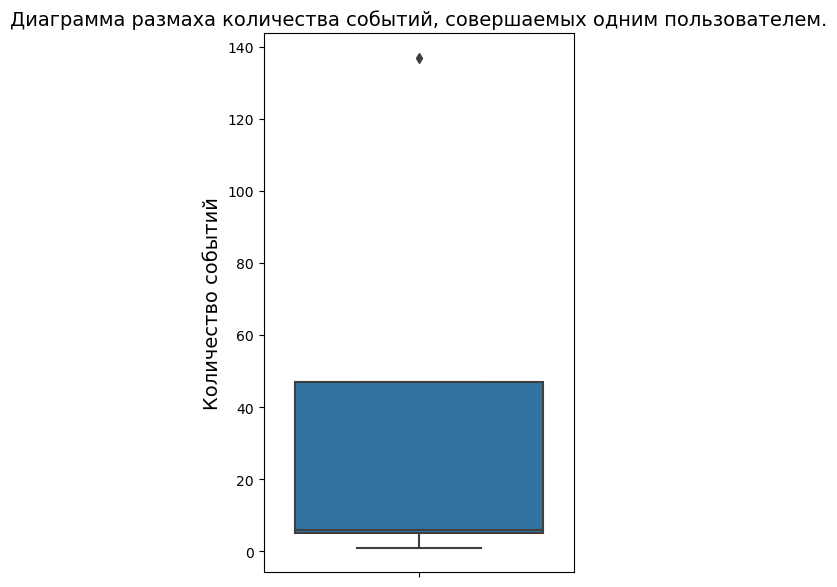

In [100]:
plt.figure(figsize=(4, 7))

sns.boxplot(y = 'event', data = event_num)

plt.title('Диаграмма размаха количества событий, совершаемых одним пользователем.', fontsize=14)
plt.ylabel('Количество событий', fontsize=14)
plt.show()

In [101]:
event_num.describe()

,event
count,5.000000
mean,39.200000
std,57.785811
min,1.000000
25%,5.000000
50%,6.000000
75%,47.000000
max,137.000000


Из данного расчета можно сделать вывод, что имеется один пользователь, совершивший 137 событий, что является аномальным, что и повлияло на расчет среднего. Чаще всего пользователи совершали от 5 до 47 событий.

Определим период времени, за который были собраны имеющиеся данные. Для этого найдем минимальное и максимальное значение столбца `event_time`.

In [102]:
data_raw['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [103]:
data_raw['event_time'].max()

Timestamp('2019-08-07 21:15:17')

Построим столбчатую диаграмму, отражающую изменение ежедневного количества событий для всего массива данных.

In [104]:
data_hist = data_raw.pivot_table(index='date', values='event', aggfunc='count').reset_index()

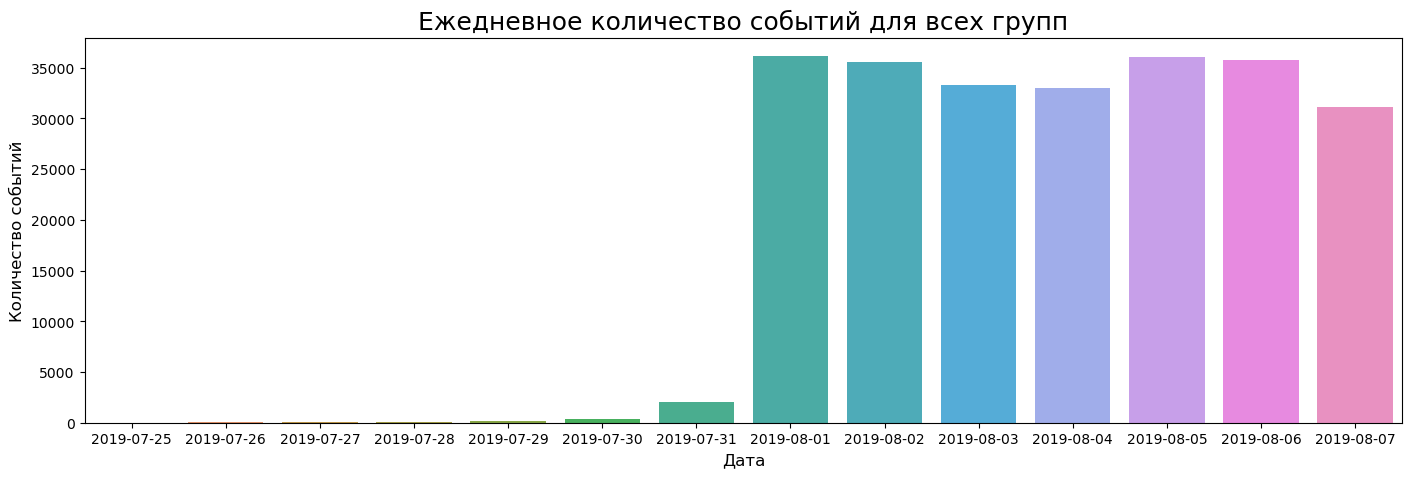

In [105]:
plt.figure(figsize=(17, 5))
sns.barplot(x='date', y='event', data=data_hist)


plt.title('Ежедневное количество событий для всех групп', fontsize=18)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.show()

Построим гистограммы, отражающие изменение ежедневного количества событий для каждой из трех групп.

Ежедневное количество событий отдельно по группам:


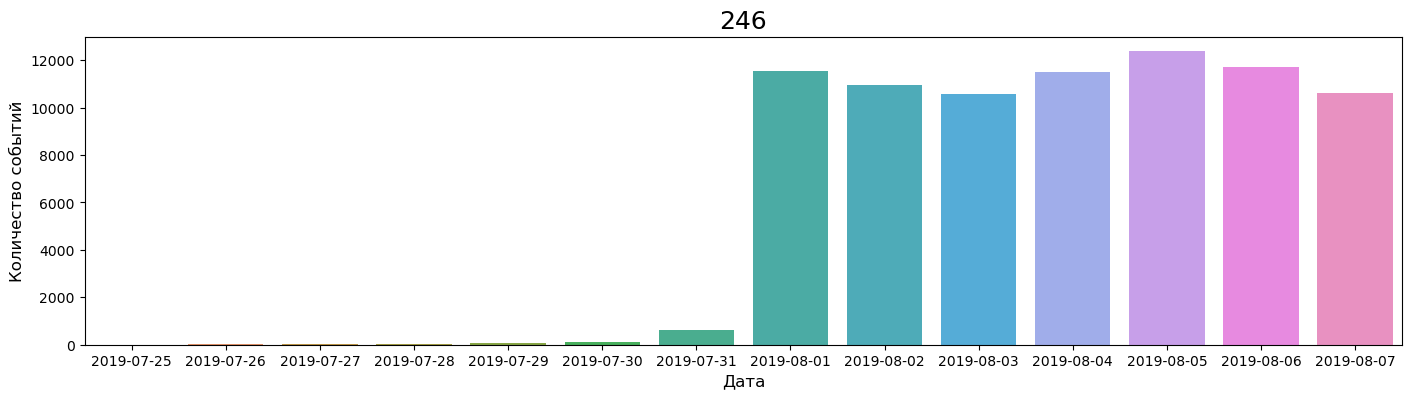

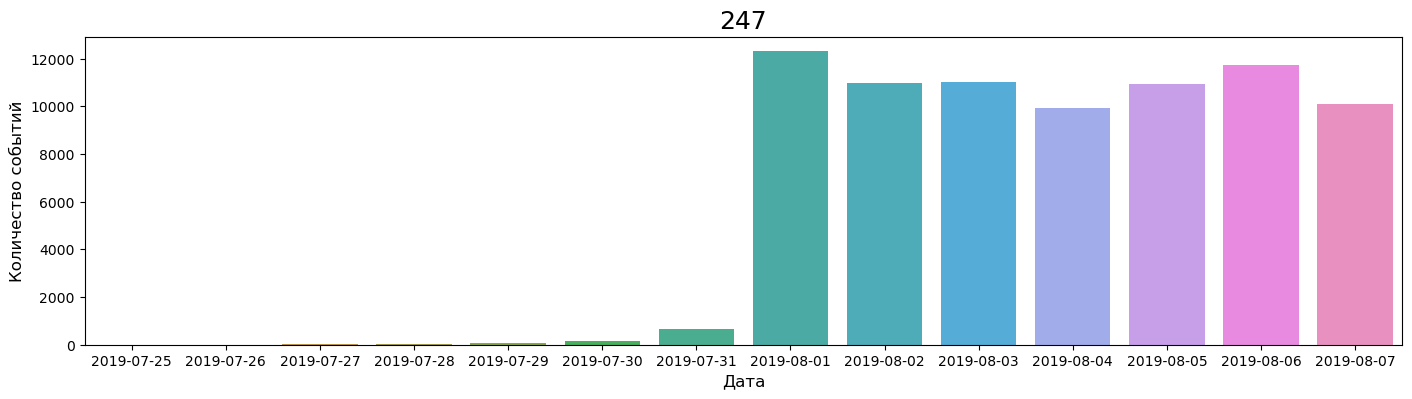

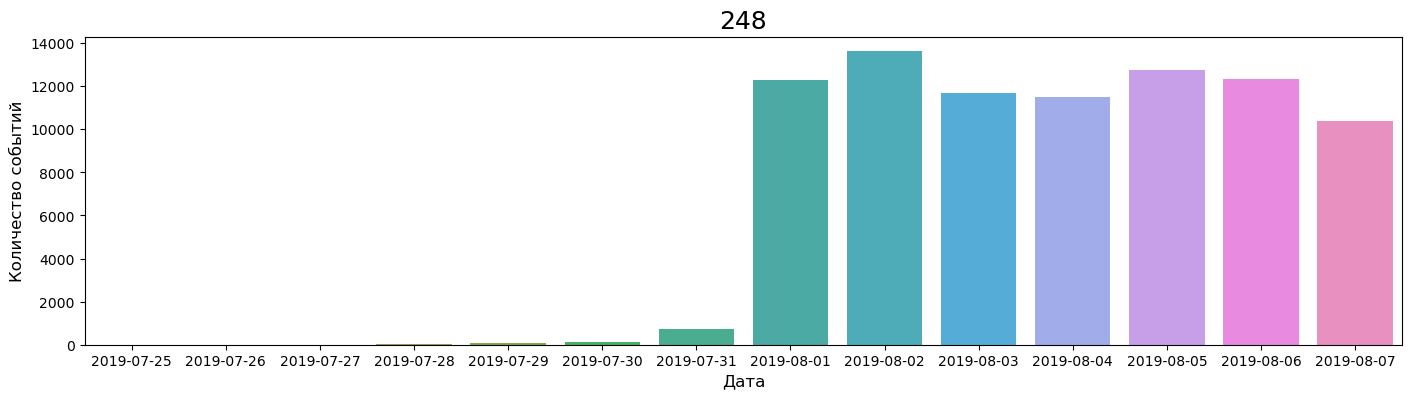

In [106]:
print('Ежедневное количество событий отдельно по группам:')

for gr, diagram in data_raw.groupby('group'):
    plt.figure(figsize=(17, 4))
    diagram = data_raw.query('group == @gr').pivot_table(index='date', values='event', aggfunc='count').reset_index()
    sns.barplot(x='date', y='event', data=diagram)
    
    plt.title(gr, fontsize=18)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество событий', fontsize=12)

Из полученных диаграмм видно, что тенденции в поведении пользователей в целом одинаковы. В первые 7 дней эксперимента активность пользователей была близка к нулю во всех группах и начала расти только с 30.07.2019. Далее, 01.08.2019 наблюдался резкий скачок в активности среди всех групп. Согласно заданию к проекту, предпосылок для резкого скачка активности в этот день обозначено не было. В связи с этим, можно предположить, что данные за первую половину исследуемого периода неполные и связанные с техническими особенностями. В связи с этим, для устранения вероятности искажения исследования, удалим из датафрейма данные до 01.08.2019.

Также необходимо отметить, что согдасно данным диагреммам, поведение пользователей из экспериментальной группы 248 несколько отличалось от поведения пользователей двух других групп. Так 02.08.2019 в данной группе наблюдался подъем активности, когда в двух других был небольшой спад. К концу периода, все группы показали плавное снижение активности пользователей в приложении.

Удалим из датафрейма данные до 01.08.2019, являющиеся неполными.

In [107]:
data = data_raw.query('event_time >= "2019-08-01"')

Таким образом, в ходе проведения исследования мы будем располагать данными за одну неделю с 01.08.2019 по 07.08.2019.

Проверим, какой объем данных был удален:

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   date        240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB


In [109]:
print('Процент удаленных данных составляет {0:.2%}'.format(len(data_raw) / len(data) - 1))

Процент удаленных данных составляет 1.17%


Процент удаленных данных составил 1,17%, что является незначительным. 

Проверим корректность удаления данных, получив все уникальные даты, оставлиеся в массиве.

In [110]:
data['date'].unique()

array([datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

Проверим изменение количества пользователей и событий до и после удаления данных о половине периода.

In [111]:
users_data_raw = (data_raw
                  .groupby(by = ['group', 'event'])
                  .agg({'user_id':'nunique', 'event':'count'}))
users_data_raw = users_data_raw.rename(columns = {'user_id':'users_data_raw', 'event':'events_number_raw'})

users_data = (data
                  .groupby(by = ['group', 'event'])
                  .agg({'user_id':'nunique', 'event':'count'}))
users_data = users_data.rename(columns = {'user_id':'users_data', 'event':'events_number'})

changes = users_data_raw.merge(users_data, on = ['group', 'event'])

changes

users_data_raw  events_number_raw  users_data  \
group event                                                                    
246   CartScreenAppear                   1270              14798        1266   
      MainScreenAppear                   2456              38249        2450   
      OffersScreenAppear                 1545              14904        1542   
      PaymentScreenSuccessful            1202              11912        1200   
      Tutorial                            279                318         278   
247   CartScreenAppear                   1240              12548        1238   
      MainScreenAppear                   2482              39677        2476   
      OffersScreenAppear                 1530              15341        1520   
      PaymentScreenSuccessful            1160              10039        1158   
      Tutorial                            286                345         283   
248   CartScreenAppear                   1239              15322        1230   
      MainScreenAppear                   2501              41175        2493   
      OffersScreenAppear                 1538              16563        1531   
      PaymentScreenSuccessful            1185              12167        1181   
      Tutorial                            282                355         279   

                               events_number  
group event                                   
246   CartScreenAppear                 14690  
      MainScreenAppear                 37676  
      OffersScreenAppear               14767  
      PaymentScreenSuccessful          11852  
      Tutorial                           317  
247   CartScreenAppear                 12434  
      MainScreenAppear                 39090  
      OffersScreenAppear               15179  
      PaymentScreenSuccessful           9981  
      Tutorial                           338  
248   CartScreenAppear                 15179  
      MainScreenAppear                 40562  
      OffersScreenAppear               16387  
      PaymentScreenSuccessful          12085  
      Tutorial                           350

После проведенной очестки данных, произошли незначительные уменьшения как в количестве событий, так и в количестве уникальных пользователей. Пользователи как и события имеются во всех трех рассматриваемых группах.

Рассчитаем абсолютные и относительные показатели изменения данных величин.

**Изменение количества событий:**

In [112]:
changes_events = (changes
                  .groupby(by = ['group'])
                  .agg({'events_number_raw':'sum', 'events_number':'sum'}))

changes_events['difference'] = changes_events['events_number'] - changes_events['events_number_raw']
changes_events['percent'] = changes_events['events_number']/changes_events['events_number_raw'] - 1

for i in changes_events.index:    
    changes_events.loc[i, 'percent'] = '{:.2%}'.format(changes_events.loc[i, 'percent'])
    
changes_events

,events_number_raw,events_number,difference,percent
group,,,,
246,80181,79302,-879,-1.10%
247,77950,77022,-928,-1.19%
248,85582,84563,-1019,-1.19%


В результате сокращения периода, количество событий уменьшилось от 879 до 1019, наибольшее уменьшение произошло в группе 248. Поскольку в процентном выражение такие изменения составили не более 1.19%, данные корректировки не могут повлиять на результаты исследования. 

**Изменение количества пользователей:**

In [113]:
changes_users = (changes
                  .groupby(by = ['group'])
                  .agg({'users_data_raw':'sum', 'users_data':'sum'}))

changes_users['difference'] = changes_users['users_data'] - changes_users['users_data_raw']
changes_users['percent'] = changes_users['users_data']/changes_users['users_data_raw'] - 1

for i in changes_users.index:    
    changes_users.loc[i, 'percent'] = '{:.2%}'.format(changes_users.loc[i, 'percent'])
    
changes_users

,users_data_raw,users_data,difference,percent
group,,,,
246,6752,6736,-16,-0.24%
247,6698,6675,-23,-0.34%
248,6745,6714,-31,-0.46%


В результате сокращения периода, количество уникальных пользователей уменьшилось от 16 до 31, наибольшее уменьшение произошло в группе 248. В процентном выражение такие изменения составляют менее 0.5%, что является незначительным изменением.

## Воронка событий

Рассмотрим виды событий и насколько часто они встречаются.

In [114]:
data_events = data.pivot_table(index = 'event', values = 'event_time', aggfunc = 'count')
data_events = data_events.rename(columns = {'event_time':'event_number'})

data_events.sort_values(by = 'event_number', ascending = False).reset_index()

,event,event_number
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Наиболее часто встречающимся событием является MainScreenAppear, самое редкое событие - Tutorial.

Определим количество уникальных пользователей, которые совершали каждое из этих событий.

In [115]:
data_users = data.groupby('event', as_index = False).agg({'event_time':'count', 'user_id':'nunique'})
data_users = data_users.rename(columns = {'event_time':'event_number', 'user_id':'user_number'})

data_users.sort_values(by = 'user_number', ascending = False).reset_index(drop=True)

,event,event_number,user_number
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


Рассчитаем долю пользователей, которые хоть раз совершали каждое из данных событий. Для этого определим общее количество уникальных пользователей, после чего число участников каждого события на данное число.

In [116]:
all_users = len(data['user_id'].unique())

In [117]:
data_users['active_part'] = round((data_users['user_number'] / all_users), 2)
data_users.sort_values(by = 'active_part', ascending = False).reset_index(drop=True)

,event,event_number,user_number,active_part
0,MainScreenAppear,117328,7419,0.98
1,OffersScreenAppear,46333,4593,0.61
2,CartScreenAppear,42303,3734,0.50
3,PaymentScreenSuccessful,33918,3539,0.47
4,Tutorial,1005,840,0.11


Учитывая данные в полученной таблице, можно сделать вывод, что воронка событий может быть представлена в последовательности представленной сортировки:
1. MainScreenAppear 
2. OffersScreenAppear 
3. CartScreenAppear 
4. PaymentScreenSuccessful

В воронке стоит учитывать все события кроме Tutorial, поскольку это обучаюшая страница, не влияющая на воронку событий, представляющую собой процесс оформления заказа продуктов в приложении. Только 11% от всех пользователей нуждались в изучении данной информации.

В связи с этим, удалим из воронки данные о событии Tutorial, после чего рассчитаем конверсию пользователей (долю перехода на каждый шаг воронки по отношению к предыдущему шагу).

In [118]:
data_users_funnel = (data_users
              .query('event != "Tutorial"')
              .sort_values(by = 'user_number', ascending = False).reset_index(drop=True))

del data_users_funnel['active_part']

for i in data_users_funnel.index:
    if i==0:
        data_users_funnel.loc[i, 'conversion'] = 1
    else:
        data_users_funnel.loc[i, 'conversion'] = round((data_users_funnel.loc[i, 'user_number'] / data_users_funnel.loc[(i-1), 'user_number']), 2)
   

In [119]:
data_users_funnel

,event,event_number,user_number,conversion
0,MainScreenAppear,117328,7419,1.00
1,OffersScreenAppear,46333,4593,0.62
2,CartScreenAppear,42303,3734,0.81
3,PaymentScreenSuccessful,33918,3539,0.95


Наибольшее количество пользователей теряется при переходе от MainScreenAppear к OffersScreenAppear, только 62% пользователей переходит на второй этап.

Наиболее эффективным переходом является переход от CartScreenAppear к PaymentScreenSuccessful, т.е. 95% пользователей, положивших товары в корзину, оплачивают свои покупки.

Рассчитаем долю пользователей, которые доходят от первого события до оплаты:

In [120]:
total_conversion = round((data_users_funnel.loc[(len(data_users_funnel.index)-1), 'user_number'] / data_users_funnel.loc[0, 'user_number']), 2)

print('Процент пользователей, которые доходят от первого события до оплаты: {0:.2%}'.format(total_conversion))


Процент пользователей, которые доходят от первого события до оплаты: 48.00%


Отобразим воронку событий графически.

In [121]:
fig = go.Figure(go.Funnel(
    y = data_users_funnel['event'],
    x = data_users_funnel['user_number'],
    textinfo = 'value+percent initial',
    marker = {'color': ['darkcyan', 'lightseagreen', 'lightskyblue', 'cornflowerblue']},
    ))

fig.update_layout(title="Воронка событий",
                  yaxis_title="Тип события"
                 )
fig.show()

На полученном графике наглядно отображено, что наибольшая потеря пользователей происходит при переходе с этапа MainScreenAppear на OffersScreenAppear.

## Результаты эксперимента

Количество пользователей в каждой экспериментальной группе составляет:

In [122]:
(data
 .query('group == 246 or group == 247')
 .groupby('group')
 .agg({'user_id':'nunique'}))

,user_id
group,
246,2484
247,2513


Проверим, имеется ли статистическая разница между выборками.

**Нулевая гипотеза** - Выборки 246 и 247 не имеют статистически значимой разницы

**Альтернативная гипотеза** - Выборки 246 и 247 разные

In [123]:
users_days = data.groupby(by = ['group', 'date'], as_index = False).agg({'user_id':'nunique'})

In [124]:
group_one_days = users_days.query('group == 246')
group_two_days = users_days.query('group == 247')

In [125]:
alpha = 0.05

In [126]:
result = stats.ttest_ind(group_one_days['user_id'], group_two_days['user_id'])

print('р-значение:', round(result.pvalue, 4))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отверкнуть нулевую гипотезу')

р-значение: 0.309
Не получилось отверкнуть нулевую гипотезу


Согласно проведенному тесту, выборки 246 и 247 не имеют статистически значимой разницы, а значит две контрольные группы для А/А-эксперимента корректны.

Как было выявлено в предыдущем разделе, самым популярным событием является `MainScreenAppear`. Определим количество пользователей в каждой из групп, совершивших это событие и проверим будет ли отличие между группами статистически достоверным.

Данные расчеты поместим в функцию `group_difference`, для ее дальнейшего использования в проверке гипотез.

In [127]:
def group_difference(first_group, second_group, event_name):
    
    #Выделим из общего датафрейма данные по рассматриваемому событию, сгруппируем их по группам, 
    #рассчитав суммарное количество пользователей, участвовавших в данном событии, для каждой группы
    users_event = (data
                   .query('event == @event_name')
                   .groupby(by = 'group', as_index = False)
                   .agg({'user_id':'nunique'}))
    users_event = users_event.rename(columns = {'user_id':'users_event'})
    
    #Для каждой группы рассчитаем общее количество пользователей 
    users_group = data.groupby(by = 'group', as_index = False).agg({'user_id':'nunique'})
    users_group = users_group.rename(columns = {'user_id':'users_number'})
    
    #Объединим таблицу с общим количеством пользователей в группе и количеством пользователей, 
    #участвовавших в событии
    part_users = users_group.merge(users_event, on = 'group')
    
    
    if first_group == 246 or first_group == 247 or first_group == 248:

    #Из полученной таблицы выделим данные для каждой группы для их использования в дальнейших расчетах
        first_part_users = part_users.query('group == @first_group').reset_index(drop=True)
        second_part_users = part_users.query('group == @second_group').reset_index(drop=True)
    
        successes1 = first_part_users.loc[0, 'users_event']
        successes2 = second_part_users.loc[0, 'users_event']
    
        users1 = first_part_users.loc[0, 'users_number']
        users2 = second_part_users.loc[0, 'users_number']
    else:           
        first_part_users = part_users.query('group == 246').reset_index(drop=True)
        second_part_users = part_users.query('group == 247').reset_index(drop=True)
        test_part_users = part_users.query('group == 248').reset_index(drop=True)
    
    #Рассматриваем объединенную контрольную группу в successes1
        successes1 = first_part_users.loc[0, 'users_event'] + second_part_users.loc[0, 'users_event']
        successes2 = test_part_users.loc[0, 'users_event']
    
    #Рассматриваем объединенную контрольную группу в users1
        users1 = first_part_users.loc[0, 'users_number'] + second_part_users.loc[0, 'users_number']
        users2 = test_part_users.loc[0, 'users_number']
    
    p1 = successes1 / users1
    p2 = successes2 / users2
        
    p_combined = (successes1 + successes2)/(users1 + users2)
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users1 + 1/users2))
    distr = stats.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('р-значение:', round(p_value, 4))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
   
    return 

Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 247, участвовавшими в событии `MainScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [128]:
group_difference(246, 247, 'MainScreenAppear')

р-значение: 0.7571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 247, участвовавшими в событии `OffersScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [129]:
group_difference(246, 247, 'OffersScreenAppear')

р-значение: 0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 247, участвовавшими в событии `CartScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [130]:
group_difference(246, 247, 'CartScreenAppear')

р-значение: 0.2288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 247, участвовавшими в событии `PaymentScreenSuccessful`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [131]:
group_difference(246, 247, 'PaymentScreenSuccessful')

р-значение: 0.1146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод:** Согласно проведенным проверкам гипотез отдельно для каждого события для групп 246 и 247, какой либо значимой статистической разницы между этими группами выявлено не было. В связи с этим можно сделать вывод, что разбиение на группы работает корректно. 

Проведем аналогичные проверки гипотез для всех событий в отношении сочетания каждой контрольной группы с экспериментальной группой.

Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 248, участвовавшими в событии `MainScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [132]:
group_difference(246, 248, 'MainScreenAppear')

р-значение: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 247 и 248, участвовавшими в событии `MainScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [133]:
group_difference(247, 248, 'MainScreenAppear')

р-значение: 0.4587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 248, участвовавшими в событии `OffersScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [134]:
group_difference(246, 248, 'OffersScreenAppear')

р-значение: 0.2084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 247 и 248, участвовавшими в событии `OffersScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [135]:
group_difference(247, 248, 'OffersScreenAppear')

р-значение: 0.9198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 248, участвовавшими в событии `CartScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [136]:
group_difference(246, 248, 'CartScreenAppear')

р-значение: 0.0784
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 247 и 248, участвовавшими в событии `CartScreenAppear`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [137]:
group_difference(247, 248, 'CartScreenAppear')

р-значение: 0.5786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 246 и 248, участвовавшими в событии `PaymentScreenSuccessful`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [138]:
group_difference(246, 248, 'PaymentScreenSuccessful')

р-значение: 0.2123
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из групп 247 и 248, участвовавшими в событии `PaymentScreenSuccessful`. 

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [139]:
group_difference(247, 248, 'PaymentScreenSuccessful')

р-значение: 0.7373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод:** Все проведенные тесты с принятым уровнем статистической значимости alpha=0.05 показали, что какой либо разницы в долях в исследуемых группах (как контрольных, так и экспериментальной) нет по всем событиям. 

Сравним экспериментальную группу с объединенной контрольной группой. Для этого так же применим созданную ранее функцию `group_difference`.

Проверим, имеется ли статистическая разница между долями пользователей из объединенной контрольной группой и 248, участвовавшими в событии MainScreenAppear.

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [140]:
group_difference('246+247', 248, 'MainScreenAppear') 

р-значение: 0.2942
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из объединенной контрольной группой и 248, участвовавшими в событии OffersScreenAppear.

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [141]:
group_difference('246+247', 248, 'OffersScreenAppear')

р-значение: 0.4343
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из объединенной контрольной группой и 248, участвовавшими в событии CartScreenAppear.

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [142]:
group_difference('246+247', 248, 'CartScreenAppear')

р-значение: 0.1818
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим, имеется ли статистическая разница между долями пользователей из объединенной контрольной группой и 248, участвовавшими в событии PaymentScreenSuccessful.

**Нулевая гипотеза** - Между долями пользователей двух групп нет статистически значимой разницы.

**Альтернативная гипотеза** - Между долями пользователей двух групп есть значимая разница.

In [143]:
group_difference('246+247', 248, 'PaymentScreenSuccessful')

р-значение: 0.6004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод:** Статистически значимой разницы между экспериментальной и объединенной контрольной группой так же выявлено не было. 

В ходе проведения эксперимента на неизмененных данных, суммарно было проведено 16 экспериментов. Это является множественным тестом.

In [144]:
number_of_control = 16

При проведении неоднократных сравнений, проводимых на одних и тех же данных, с каждой новой проверкой гипотезы растет вероятность ошибки первого рода. Для избежания данной ошибки необходимо применить метод корректировки уровня значимости для уменьшения групповой вероятности ошибки первого рода. Поскольку в данной ситуации ни одна из гипотез не была отвергнута даже при применении неизмененного коэффициента, перерасчет можно не выполнять. В данном проекте проведем его для дополнительной перепроверки результатов.

Для данной корректировки применим метод Шидака. Рассчитаем новое значение уровня статистической значимости.

In [145]:
alpha = 1 - (1 - alpha)**(1 / number_of_control)

In [146]:
round(alpha, 4)

0.0032

Применим данный уровень статистической значимости для повтора расчета всех 16 экспериментов, проведенных ранее.

In [147]:
group_difference(246, 247, 'MainScreenAppear')

р-значение: 0.7571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [148]:
group_difference(246, 247, 'OffersScreenAppear')

р-значение: 0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [149]:
group_difference(246, 247, 'CartScreenAppear')

р-значение: 0.2288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [150]:
group_difference(246, 247, 'PaymentScreenSuccessful')

р-значение: 0.1146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [151]:
group_difference(246, 248, 'MainScreenAppear')

р-значение: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [152]:
group_difference(247, 248, 'MainScreenAppear')

р-значение: 0.4587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [153]:
group_difference(246, 248, 'OffersScreenAppear')

р-значение: 0.2084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [154]:
group_difference(247, 248, 'OffersScreenAppear')

р-значение: 0.9198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [155]:
group_difference(246, 248, 'CartScreenAppear')

р-значение: 0.0784
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [156]:
group_difference(247, 248, 'CartScreenAppear')

р-значение: 0.5786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [157]:
group_difference(246, 248, 'PaymentScreenSuccessful')

р-значение: 0.2123
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [158]:
group_difference(247, 248, 'PaymentScreenSuccessful')

р-значение: 0.7373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [159]:
group_difference('246+247', 248, 'MainScreenAppear') 

р-значение: 0.2942
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [160]:
group_difference('246+247', 248, 'OffersScreenAppear') 

р-значение: 0.4343
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [161]:
group_difference('246+247', 248, 'CartScreenAppear') 

р-значение: 0.1818
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [162]:
group_difference('246+247', 248, 'PaymentScreenSuccessful') 

р-значение: 0.6004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод:** В соответствии с проведенным расчетом на основе уточненного коэффициента статистического уровня значимости между долями во всех сочетаниях трех групп нет статистически значимой разницы.

# Вывод по проекту.

В данном проекте был проведен анализ поведения пользователей мобильного приложения по продаже продуктов питания, а также анализ результатов А/А/В-эксперимента, проводимого с целью получения информации о реакции пользователей на изменение шрифтов во всем приложении. 

В ходе проведения данного исследования были проведены:

- проверка данных, которая показала наличие дубликатов в имеющемся массиве данных, а также имеющиеся ошибки в части формата данных и формата названий столбцов, а так же наличия периода, содержащего неполные данные. Все имеющиеся недостатки были устранены.
- анализ воронки событий, который показал, что наибольшее количество пользователей теряется при переходе от события MainScreenAppear к OffersScreenAppear (только 62% пользователей переходит на второй этап). На данном этапе стоит рассмотреть внедрение улучшений с целью увеличения конверсии. Наиболее эффективным переходом является переход от CartScreenAppear к PaymentScreenSuccessful, т.е. 95% пользователей, положивших товары в корзину, оплачивают свои покупки. Конверсия от первого события в воронке до последнего составляет 48%.
- анализ результатов эксперимента, который был проведен с применение двух коэффициентов статистической значимости: учитывающим и не учитывающим множественный тест, проводимый на неизмененных данных. Ни один из проведенных экспериментов не показал наличие статистически значимой разницы между долями. Это позволяет предположить, что в целом изменение шрифтов в приложении никак не влияет на поведение пользователей, в связи с чем данное изменение может быть применено.